<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

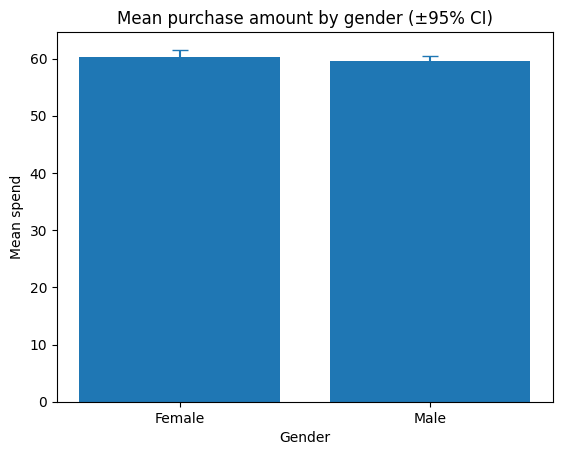

Columns missing for chi-square.
Pearson r(age, amount) = -0.010, p=0.5152, n=3900


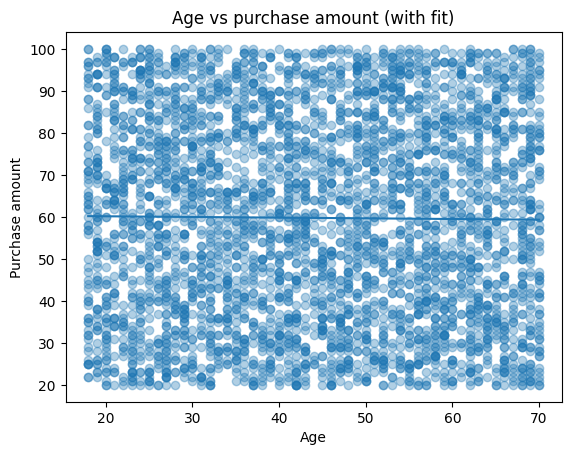

In [13]:
# CP2 — Customer Shopping Trends
# If your CSV is named differently, update DATA_PATH below.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path
import re

pd.set_option("display.max_columns", 100)

DATA_PATH = Path("shopping_trends_updated.csv")
df = pd.read_csv(DATA_PATH)
df.head(3)
def find_col(candidates):
    pat = re.compile("|".join([fr"\b{re.escape(c)}\b" for c in candidates]), re.I)
    for c in df.columns:
        if pat.search(c):
            return c
    return None

COLS = {
    "date": find_col(["date"]),
    "age": find_col(["age"]),
    "gender": find_col(["gender", "sex"]),
    "amount": find_col(["amount", "purchase amount", "price", "total", "spent"]),
    "category": find_col(["category", "product category", "item category"]),
    "item": find_col(["item", "product", "item purchased"]),
    "payment": find_col(["payment", "payment method", "pay method"]),
    "return": find_col(["return", "is_returned", "returned"]),
    "rating": find_col(["rating", "review", "review rating"]),
    "city": find_col(["city"]),
    "state": find_col(["state"]),
}

COLS
df_clean = df.copy()

if COLS["date"]:
    df_clean[COLS["date"]] = pd.to_datetime(df_clean[COLS["date"]], errors="coerce")
for k in ["age", "amount", "rating"]:
    col = COLS[k]
    if col:
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")
for k in ["gender", "category", "item", "payment", "city", "state"]:
    col = COLS[k]
    if col and df_clean[col].dtype == object:
        df_clean[col] = (
            df_clean[col]
            .astype(str)
            .str.strip()
            .str.replace(r"\s+", " ", regex=True)
            .str.title()
        )
if COLS["gender"]:
    g = df_clean[COLS["gender"]].str[:1].str.upper()
    df_clean[COLS["gender"]] = np.where(g.eq("F"), "Female",
                                  np.where(g.eq("M"), "Male", "Other"))
if COLS["return"]:
    if df_clean[COLS["return"]].dtype == object:
        df_clean[COLS["return"]] = df_clean[COLS["return"]].str.strip().str.lower().map({
            "yes": 1, "y": 1, "true": 1, "1": 1,
            "no": 0, "n": 0, "false": 0, "0": 0
        })
    df_clean[COLS["return"]] = pd.to_numeric(df_clean[COLS["return"]], errors="coerce").astype("float")

df_clean.info()
missing = df_clean.isna().sum().sort_values(ascending=False)
missing[missing>0]
if COLS["amount"]:
    df_clean = df_clean[df_clean[COLS["amount"]].notna() & (df_clean[COLS["amount"]] > 0)]

if COLS["age"]:
    df_clean = df_clean[(df_clean[COLS["age"]].between(10, 100))]
df_clean.shape
desc = df_clean[[c for c in [COLS["amount"], COLS["age"], COLS["rating"]] if c]].describe().T
desc

amount = COLS["amount"]; gender = COLS["gender"]

groups = (
    df_clean[[amount, gender]]
    .dropna()
    .groupby(gender)[amount]
)

if set(groups.groups) >= {"Female", "Male"}:
    x = groups.get_group("Female").values
    y = groups.get_group("Male").values
    t_stat, p_val = stats.ttest_ind(x, y, equal_var=False)
    print(f"T-test Female vs Male: t={t_stat:.3f}, p={p_val:.4g}, nF={len(x)}, nM={len(y)}")
else:
    print("Gender groups not available for t-test.")

agg = (
    df_clean[[amount, gender]]
    .dropna()
    .groupby(gender)[amount]
    .agg(['mean','count','std'])
    .reset_index()
)
agg["se"] = agg["std"] / np.sqrt(agg["count"])
agg["lo"] = agg["mean"] - 1.96*agg["se"]
agg["hi"] = agg["mean"] + 1.96*agg["se"]

plt.figure()
plt.bar(agg[gender], agg["mean"])
plt.errorbar(agg[gender], agg["mean"], yerr=[agg["mean"]-agg["lo"], agg["hi"]-agg["mean"]], fmt='none', capsize=6)
plt.xlabel("Gender"); plt.ylabel("Mean spend")
plt.title("Mean purchase amount by gender (±95% CI)")
plt.show()

payment = COLS["payment"]; ret = COLS["return"]

if payment and ret:
    ct = pd.crosstab(df_clean[payment].dropna(), df_clean[ret].dropna())
    if ct.shape[0] >= 2 and ct.shape[1] >= 2:
        chi2, p, dof, exp = stats.chi2_contingency(ct)
        print("Chi-square payment vs return:")
        print(f"chi2={chi2:.3f}, dof={dof}, p={p:.4g}")
        display(ct)
    else:
        print("Not enough categories for chi-square.")
else:
    print("Columns missing for chi-square.")

if payment and ret:
    rates = (
        df_clean[[payment, ret]]
        .dropna()
        .groupby(payment)[ret]
        .mean()
        .sort_values(ascending=False)
    )
    plt.figure()
    plt.bar(rates.index.astype(str), rates.values)
    plt.ylabel("Return rate")
    plt.xlabel("Payment method")
    plt.title("Return rate by payment method")
    plt.xticks(rotation=30, ha='right')
    plt.show()
age = COLS["age"]; amount = COLS["amount"]

xy = df_clean[[age, amount]].dropna()
if not xy.empty:
    r, p = stats.pearsonr(xy[age], xy[amount])
    print(f"Pearson r(age, amount) = {r:.3f}, p={p:.4g}, n={len(xy)}")
else:
    print("No overlapping age/amount data.")

xy = df_clean[[age, amount]].dropna()
if not xy.empty:
    slope, intercept, r_value, p_value, std_err = stats.linregress(xy[age], xy[amount])
    xgrid = np.linspace(xy[age].min(), xy[age].max(), 100)
    yhat = intercept + slope * xgrid

    plt.figure()
    plt.scatter(xy[age], xy[amount], alpha=0.35)
    plt.plot(xgrid, yhat)
    plt.xlabel("Age"); plt.ylabel("Purchase amount")
    plt.title("Age vs purchase amount (with fit)")
    plt.show()
category = COLS["category"]
if category and amount:
    cat_sum = (
        df_clean.groupby(category)[amount]
        .agg(["count","mean","median","std"])
        .sort_values("mean", ascending=False)
        .head(10)
    )
    cat_sum